<a href="https://colab.research.google.com/github/miladshiraniUCB/dsc-phase-3-project-from-kaggle/blob/main/Copy_of_index_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Do:

* add Confusion matrix
* add classification report
* do not use accuracy

# Introduction

In this project by using the available data from [kaggle.com](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) we try to create a model to predict if a person will have heart disease in future or not. 

# Importing Data and Libraries we use 

In [ ]:
! git clone https://github.com/miladshiraniUCB/dsc-phase-3-project-from-kaggle.git

Cloning into 'dsc-phase-3-project-from-kaggle'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 5), reused 17 (delta 2), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
import numpy as np
import pandas as pd
import io

from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE, ADASYN


# from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv("/content/dsc-phase-3-project-from-kaggle/heart_2020_cleaned.csv")
df.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [ ]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

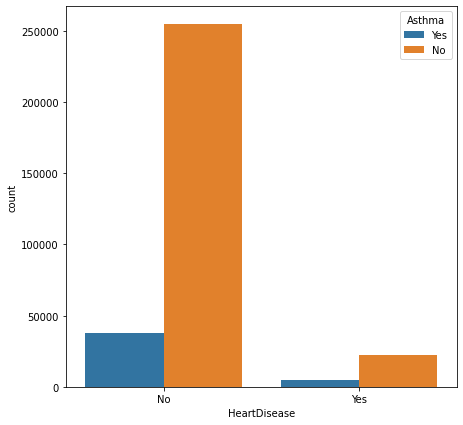

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="Asthma");

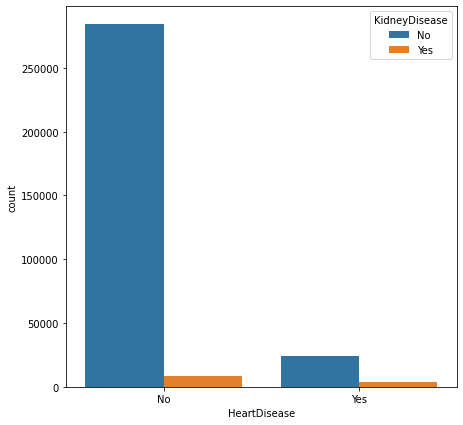

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="KidneyDisease");

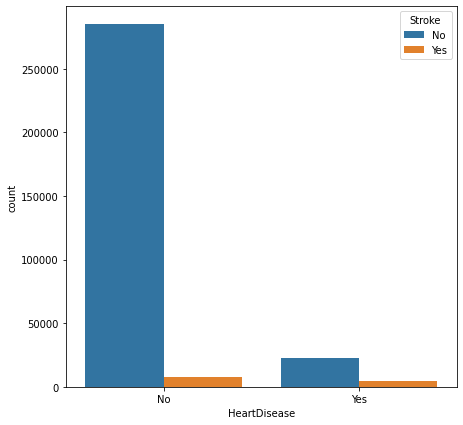

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="Stroke");

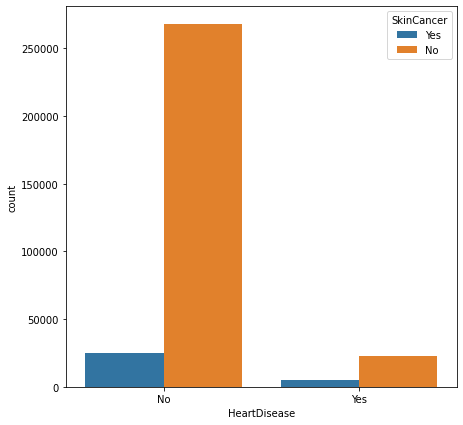

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="SkinCancer");

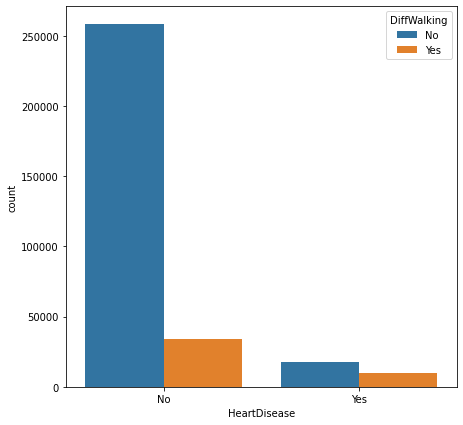

In [ ]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="DiffWalking");

In [ ]:
# plt.figure(figsize=(7,7))
# sns.countplot(data=df,x="HeartDisease",hue="MentalHealth")

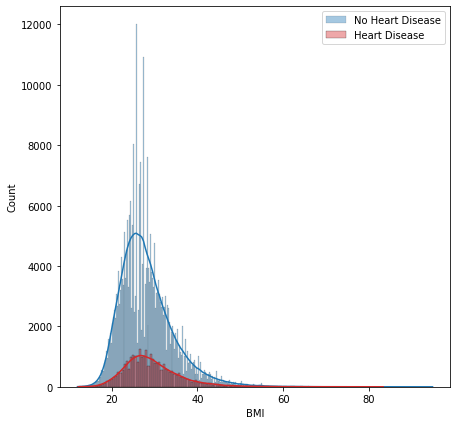

In [ ]:
plt.figure(figsize=(7,7))
sns.histplot(df.loc[df["HeartDisease"]== "No"]["BMI"], 
             color = "tab:blue", alpha = 0.4, label = "No Heart Disease", 
            kde = True)
sns.histplot(df.loc[df["HeartDisease"]== "Yes"]["BMI"], 
             color = "tab:red", alpha = 0.4, label = "Heart Disease",
            kde = True)
# plt.show()
plt.legend();

# Data Preparation 

In [ ]:
df["HeartDisease"].value_counts(normalize = True)

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64

In [ ]:
df_2 = df.copy()
Yes_No_dict = {"No":0, "Yes":1, "Female":1, "Male":0} 

Yes_No_List = ["Stroke", "HeartDisease", "Smoking", "AlcoholDrinking",
               "Asthma", "KidneyDisease", "SkinCancer", "Diabetic",
               "PhysicalActivity", "Sex", "DiffWalking"]

for col in Yes_No_List:
    df_2[col] = df_2[col].map(Yes_No_dict)

#### Encoding By using OneHotEncoder


numeric = ["BMI", "SleepTime", "PhysicalHealth", "MentalHealth"]

for item in numeric:
    Yes_No_List.append(item)
    

cat = list(df_2.columns)


for item in Yes_No_List:  
    cat.remove(item)
    

df_cat = df_2[cat]

ohe = OneHotEncoder(categories='auto', sparse=False)
#                     , drop="first")

df_cat_encoded = pd.DataFrame(np.squeeze(ohe.fit_transform(df_cat)), 
                              columns = ohe.get_feature_names())

##### Scaling By using StandardScaler

scaler = StandardScaler()

df_numeric = df_2[numeric]


scaled_numeric = scaler.fit_transform(df_numeric)

df_scaled_numeric = pd.DataFrame(np.squeeze(scaler.fit_transform(scaled_numeric)), 
                             columns = df_numeric.columns)

#### Concatating New DataFrames

X = pd.concat([df_cat_encoded, df_scaled_numeric], axis = 1)


We see that `df_2["HeartDisease"].value_counts(normalize = True)` results in

`
{{df_2["HeartDisease"].value_counts(normalize = True)}}`

which can be used to conclude that we have imbalances in our data so, we either can use `SMOTE` or we can set `stratify=y` in `train_test_split`. We noticed that setting set `stratify=y`, results in a better accuracy.

In [ ]:
y = df_2["HeartDisease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    test_size = 0.2, 
                                                    stratify=y)



smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("y_train:", dict(y_train.value_counts(normalize = True)*100))
print("y_train_smote:", dict(y_train_smote.value_counts(normalize = True)*100))
print("y_test:", dict(y_test.value_counts(normalize = True)*100))

y_train: {0: 91.44061039103175, 1: 8.559389608968246}
y_train_smote: {0: 50.0, 1: 50.0}
y_test: {0: 91.43982864022264, 1: 8.560171359777357}


# XGBoost

The following Box is from [here](https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api) and also check [this](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html)

or the first link is

```
https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api
```

and the second link is

```
https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html
```

In [ ]:
# {'alpha': 10,
#  'eval_metric': 'auc',
#  'max_depth': 10,
#  'n_estimators': 15,
#  'objective': 'binary:logistic',
#  'seed': 42}

# smote_params = {'alpha': 10,
#                 'eval_metric': 'auc',
#                 'max_depth': 10,
#                 'n_estimators': 15,
#                 'objective': 'binary:logistic',
#                 'seed': 42}


clf = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, #reg_alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

clf.fit(X_train_smote, y_train_smote);

In [ ]:
test_preds = clf.predict(X_test)
training_preds= clf.predict(X_train)

### ROC and AUC
# ROC
train_fpr, train_tpr, train_thresh = roc_curve(y_train, training_preds)
test_fpr , test_tpr , test_thresh = roc_curve(y_test, test_preds)
# AUC
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)


print('Training AUC: {:.4}'.format(train_auc))
print('Validation AUC: {:.4}'.format(test_auc))
print("Test precision_score: {:.4}".format(precision_score(y_test, test_preds)))
print("Test recall_score: {:.4}".format(recall_score(y_test, test_preds)))
print("f1_score: {:.4}".format(f1_score(y_test, test_preds)))

Training AUC: 0.7371
Validation AUC: 0.7196
Test precision_score: 0.204
Test recall_score: 0.6919
f1_score: 0.3151


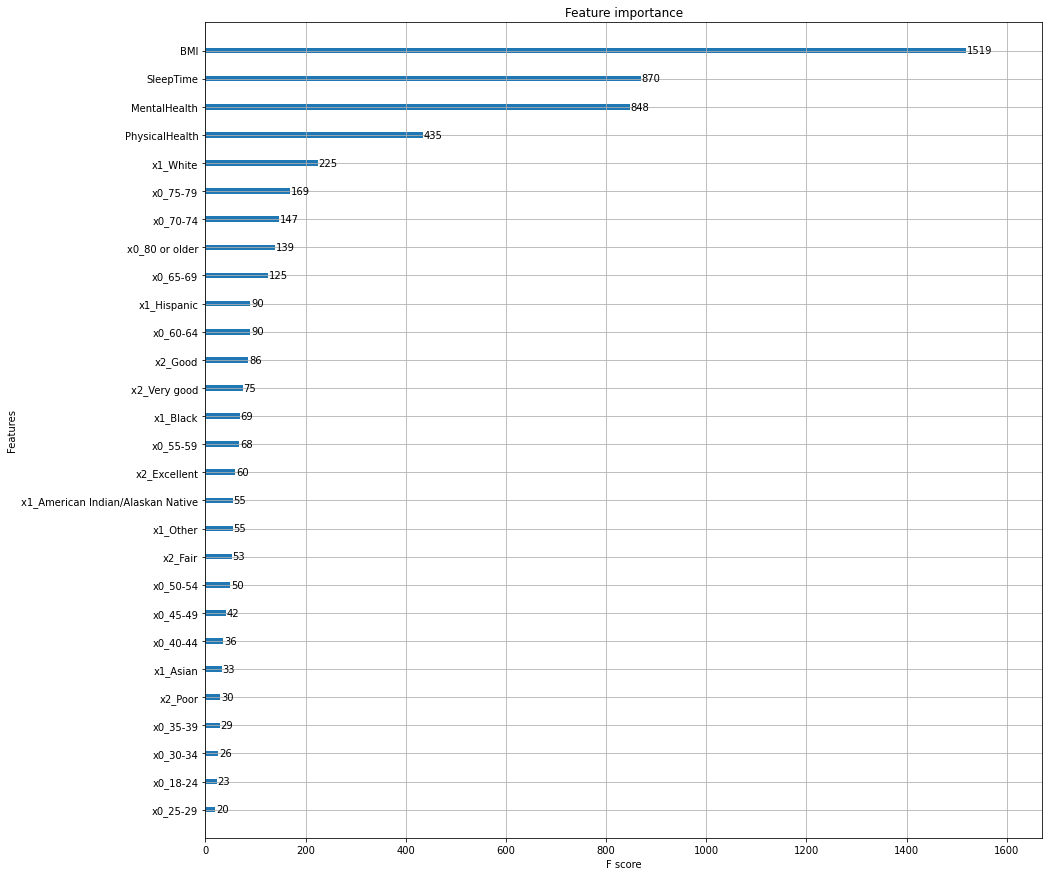

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))
xgb.plot_importance(clf, ax = ax);

## GridSearch For XGBoost 

By using GridSearch we find the following. It takes times to find it so, make sure that you are not running this section.

```python

best_parameters = {'alpha': 30,
 'eta': 0.3,
 'eval_metric': 'auc',
 'max_depth': 10,
 'n_estimators': 25,
 'objective': 'binary:logistic',
 'seed': 42}

```

the accuracy results that we find are:

```python
Training Accuracy: 91.61%
Validation accuracy: 91.6%
```

In [ ]:
clf_param_grid = {
    "max_depth": [5, 10],
    "n_estimators": [10, 15],
    "seed": [42],
    "alpha": [20, 25],
    "objective" : ['binary:logistic'], 
    "eval_metric" : ["auc"]
}

In [ ]:
clf_grid = xgb.XGBClassifier()

clf_grid_search = GridSearchCV(clf_grid, clf_param_grid, cv = None)


# Fit to the data
clf_grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'alpha': [20, 25], 'eval_metric': ['auc'],
                         'max_depth': [5, 10], 'n_estimators': [10, 15],
                         'objective': ['binary:logistic'], 'seed': [42]})

In [ ]:

test_preds_grid     = clf_grid_search.predict(X_test)


### ROC and AUC
# ROC

test_fpr_grid , test_tpr_grid , test_thresh_grid = roc_curve(y_test, test_preds_grid)
# AUC

test_auc_grid = auc(test_fpr_grid, test_tpr_grid)



print('Validation AUC: {:.4}'.format(test_auc_grid))
print("Test precision_score: {:.4}".format(precision_score(y_test, test_preds_grid)))
print("Test recall_score: {:.4}".format(recall_score(y_test, test_preds_grid)))
print("f1_score: {:.4}".format(f1_score(y_test, test_preds_grid)))

Validation AUC: 0.7196
Test precision_score: 0.204
Test recall_score: 0.6919
f1_score: 0.3151


In [ ]:
clf_grid_search.best_params_

{'alpha': 20,
 'eval_metric': 'auc',
 'max_depth': 10,
 'n_estimators': 15,
 'objective': 'binary:logistic',
 'seed': 42}

In [ ]:
# clf_grid_search.best_params_ = {'alpha': 20,
#  'eval_metric': 'auc',
#  'max_depth': 10,
#  'n_estimators': 15,
#  'objective': 'binary:logistic',
#  'seed': 42}

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion="entropy", bootstrap = True)

rf.fit(X_train_smote, y_train_smote)

training_preds_rf = rf.predict(X_train)
test_preds_rf     = rf.predict(X_test)


### ROC and AUC
# ROC
train_fpr_rf, train_tpr_rf, train_thresh_rf = roc_curve(y_train, training_preds_rf)
test_fpr_rf , test_tpr_rf , test_thresh_rf = roc_curve(y_test, test_preds_rf)
# AUC
train_auc_rf = auc(train_fpr_rf, train_tpr_rf)
test_auc_rf = auc(test_fpr_rf, test_tpr_rf)


print('Training AUC: {:.4}'.format(train_auc_rf))
print('Validation AUC: {:.4}'.format(test_auc_rf))
print("Test precision_score: {:.4}".format(precision_score(y_test, test_preds_rf)))
print("Test recall_score: {:.4}".format(recall_score(y_test, test_preds_rf)))
print("f1_score: {:.4}".format(f1_score(y_test, test_preds_rf)))

Training AUC: 0.9387
Validation AUC: 0.5822
Test precision_score: 0.1897
Test recall_score: 0.274
f1_score: 0.2241


# Microsoft FLAML A Fast Library for Automated Machine Learning & Tuning

It can be found [here](https://github.com/microsoft/FLAML) or using the following link
```https://github.com/microsoft/FLAML```


In [ ]:
! pip install flaml

     |████████████████████████████████| 157 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 35.6 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install flaml[notebook];

     |████████████████████████████████| 757 kB 7.8 MB/s 
     |████████████████████████████████| 158 kB 31.2 MB/s 
     |████████████████████████████████| 76.1 MB 42 kB/s 
  Created wheel for openml: filename=openml-0.10.2-py3-none-any.whl size=190318 sha256=88dc7d6dae91416f36f5d9c77f82f2192145bb7d9dd7059cc1f7ea626c06a173
  Stored in directory: /root/.cache/pip/wheels/9c/9e/f3/6a5ebf16527d7fe22d9bc1652bc9beb5dc9fcfdeb75e805400
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=f1661b0fc90106531cf45d5091051f8635bbf49372081c3d168636da7954a987
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff


In [ ]:
df_FLAML = df.copy()
df_FLAML["HeartDisease"] = df_FLAML["HeartDisease"].map({"No": 0 , "Yes": 1})

X_new = df_FLAML.drop("HeartDisease", axis = 1)
y_new = df_FLAML.HeartDisease


X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_new, y_new,
                                                           test_size = 0.2,
                                                           random_state = 42)

In [ ]:
from flaml import AutoML
automl = AutoML()
automl.fit(X_train_n, y_train_n, task="classification", metric = "accuracy", estimator_list=['rf','xgboost']);

[flaml.automl: 04-02 09:06:49] {2105} INFO - task = classification
[flaml.automl: 04-02 09:06:49] {2107} INFO - Data split method: stratified
[flaml.automl: 04-02 09:06:49] {2111} INFO - Evaluation method: holdout
[flaml.automl: 04-02 09:06:49] {2188} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 04-02 09:06:49] {2281} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost']
[flaml.automl: 04-02 09:06:49] {2567} INFO - iteration 0, current learner rf
[flaml.automl: 04-02 09:06:49] {2698} INFO - Estimated sufficient time budget=94858s. Estimated necessary time budget=95s.
[flaml.automl: 04-02 09:06:49] {2750} INFO -  at 1.9s,	estimator rf's best error=0.0852,	best estimator rf's best error=0.0852
[flaml.automl: 04-02 09:06:49] {2567} INFO - iteration 1, current learner xgboost
[flaml.automl: 04-02 09:06:49] {2750} INFO -  at 2.0s,	estimator xgboost's best error=0.0852,	best estimator rf's best error=0.0852
[flaml.automl: 04-02 09:06:49] {2567} INFO - iteration 2, current 

In [ ]:
y_test_pred_FLAML = automl.predict(X_test_n)
y_train_pred_FLAML = automl.predict(X_train_n)

In [ ]:
print(automl.model.estimator)

XGBClassifier(colsample_bylevel=0.8558083225981507,
              colsample_bytree=0.9930577047295022, grow_policy='lossguide',
              learning_rate=0.02192716767093768, max_depth=0, max_leaves=61,
              min_child_weight=0.9423561186199229, n_estimators=10, n_jobs=-1,
              reg_alpha=0.0009765625, reg_lambda=23.069926699761634,
              subsample=0.9377924838515587, tree_method='hist',
              use_label_encoder=False, verbosity=0)


In [ ]:
### ROC and AUC
# ROC

test_fpr_FLAML , test_tpr_FLAML , test_thresh_FLAML = roc_curve(y_test_array, y_test_pred_array)
# AUC

test_auc_FLAML = auc(test_fpr_FLAML, test_tpr_FLAML)



print('Validation AUC: {:.4}'.format(test_auc_FLAML))
print("Test precision_score: {:.4}".format(precision_score(y_test_array, y_test_pred_array)))
print("Test recall_score: {:.4}".format(recall_score(y_test_array, y_test_pred_array)))
print("f1_score: {:.4}".format(f1_score(y_test_array, y_test_pred_array)))

Training AUC: 0.5252
Validation AUC: 0.5242
Test precision_score: 0.5785
Test recall_score: 0.05204
f1_score: 0.09549
